In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [62]:
corDefault = "#6688AA"
corViridis = ['#440154', '#414487', '#2a788e', '#22a884', '#7ad151']

def set_plot_style():
    # Background colors
    plt.figure().patch.set_facecolor("0.85")
    plt.axes().set(facecolor="0.85")
    
    # Hiding grid
    plt.grid(False)
    
    # Setting only left and bottom spines as visible
    ax = plt.gca()
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Spines color
    ax.spines['bottom'].set_color("black")
    ax.spines['left'].set_color("black")
    
    # Plot size
    plt.gcf().set_size_inches(6, 5)

    # Plot Style
    plt.style.use('seaborn-v0_8-colorblind')

In [68]:
def PlotLineHue(x, y, hue, title, sx, sy, save):
    set_plot_style()
               
    sns.lineplot(x = x, y = y, hue = hue)

    plt.title(title)
                    
    plt.gcf().set_size_inches(sx, sy)

    if (save != ""):
        plt.tight_layout()
        plt.savefig(save)
                    
    plt.show()
    plt.close()

In [134]:
import statsmodels.api as sm


def PlotScatterHue(df, x, y, hue, rolling_mean, title, sx, sy, save):
    set_plot_style()

    lowess = sm.nonparametric.lowess
    smoothed = lowess(y.fillna(0), x, frac=0.1)
    
    sns.scatterplot(x = x, y = y, hue = hue)
    #plt.plot(x, rolling_mean, color = 'black')
    #plt.plot(x, smoothed[:, 1], color='black', label='LOWESS')
    sns.lmplot(x = x, y = y, data = df, ci = None)

    plt.title(title)
                    
    plt.gcf().set_size_inches(sx, sy)

    if (save != ""):
        plt.tight_layout()
        plt.savefig(save)
                    
    plt.show()
    plt.close()

# **DATASET LOADING**

In [4]:
df = pd.read_csv("../data/processed/01_Data_Cleaning.csv")
df['date'] = pd.to_datetime(df['date'])

df.head()

,date,sell_quantity,sell_value,buy_quantity,buy_value,daily_balance,inventory,avg_temperature,precipitation,incc,fuel_price,is_holiday
0,2024-01-01,NaN,NaN,NaN,NaN,0,175,24.9,0.1,0.0027,6.04,1
1,2024-01-02,163.0,32.10,280.0,28.97,117,292,25.0,0.2,0.0027,6.04,0
2,2024-01-03,215.0,31.13,NaN,28.97,-215,77,24.8,4.9,0.0027,6.04,0
3,2024-01-04,NaN,NaN,240.0,28.43,240,317,24.8,0.0,0.0027,6.04,0
4,2024-01-05,55.0,35.50,240.0,28.43,185,502,25.1,0.0,0.0027,6.04,0


# **FEATURE ENGINEERING**

## **DEMAND, SUPPLY AND STOCK DYNAMICS**

<br>
Gross margin per unit (selling price / buying price) to measure profitability. It will be the primary target variable for profit optimization.

In [8]:
df['price_margin'] = df.apply(lambda row: (row['sell_value'] / row['buy_value']) if row['sell_value'] != 0 else np.nan, axis = 1)

3-day rolling average of the daily selling and buying prices, used to smooth out short-term fluctuations and highlight trends.  
The 3-day standard deviation captures short-term volatility in selling prices.

In [10]:
df['rolling_mean_sell_value'] = df['sell_value'].rolling(window = 3, min_periods = 1).mean()
df['rolling_mean_buy_value'] = df['buy_value'].rolling(window = 3, min_periods = 1).mean()

df['rolling_std_sell_value'] = df['sell_value'].rolling(window = 3).std()

<br>
Lag features of daily quantity sold (1-day and 7-day), allowing the model to detect temporal patterns or autocorrelation in demand. As well as, previous day’s inventory value, to help understand dynamic stock variation, and 7-day rolling average of inventory, reflecting smoothed stock availability.

In [12]:
df['sell_quantity_lag_1'] = df['sell_quantity'].shift(1)
df['sell_quantity_lag_7'] = df['sell_quantity'].shift(7)

df['inventory_lag_1'] = df['inventory'].shift(1)
df['avg_inventory_rolling'] = df['inventory'].rolling(window = 7).mean()

<br>
To measure how quickly inventory is being sold relative to the previous day's stock level.

In [14]:
df['inventory_turnover'] = df['sell_quantity'] / (df['inventory_lag_1'] + 1e-6)

<br>
7-day average of quantity sold.

In [16]:
df['avg_sell_quantity_last_7d'] = df['sell_quantity'].rolling(window = 7).mean()

<br>
Daily percentage change in selling and buying prices, indicating price volatility.

In [18]:
df['sell_value_pct_change'] = df['sell_value'].pct_change().replace([np.inf, -np.inf], np.nan)
df['buy_value_pct_change'] = df['buy_value'].pct_change().replace([np.inf, -np.inf], np.nan)

## **EXOGENOUS VARIABLES: WEATHER AND HOLIDAYS**

Flags for moderate (2.5–10 mm) and heavy (≥10 mm) daily rainfall, based on Brazilian climate thresholds, which may affect sales of construction materials like cement.

In [21]:
df['is_moderate_rain'] = (df['precipitation'] >= 2.5) & (df['precipitation'] < 10)
df['is_heavy_rain'] = df['precipitation'] >= 10

In [86]:
df['precip_bin'] = pd.cut(
    df['precipitation'],
    bins = [-float('inf'), 0.1, 2.5, 10, 50, float('inf')],
    labels = ['no rain', 'light', 'moderate', 'heavy', 'torrential']
)

<br>
Temperature bins that categorize daily average temperature into three ranges based on cement curing guidelines:

- **low**: below 10 °C. May slow down or impair proper curing; 
- **optimal**: between 10 °C and 25 °C. Ideal range for cement setting and strength development;
- **high**: above 25 °C. May accelerate drying and reduce surface quality.

In [23]:
df['temperature_bin'] = pd.cut(
    df['avg_temperature'],
    bins = [-float('inf'), 10, 25, float('inf')],
    labels = ['low', 'optimal', 'high']
)

<br>
Date-based time features that help the model capture seasonal patterns in demand and pricing.

In [25]:
df['month'] = df['date'].dt.month
df['is_weekend'] = df['date'].dt.dayofweek
df['is_weekend'] = df['is_weekend'].apply(lambda x: True if x > 4 else False)
df['quarter'] = df['date'].dt.quarter

<br>
Incorporate anticipation effect.

In [27]:
k = 1
df.loc[0, 'days_until_holiday'] = 0

for i in range(1, len(df)):
    if (df.loc[i, 'is_holiday'] == 1):
        h = df.loc[i, 'date']

        for j in range(k, i):
            df.loc[j, 'days_until_holiday'] = abs((h - df.loc[j, 'date']).days)

        k = i + 1

df['days_until_holiday'] = df['days_until_holiday'].fillna(0)

## **INFLATION-AJUSTED FEATURES**

Lagged values of monthly INCC inflation rate, allowing the model to capture inflation trends and their delayed effects on pricing.

In [30]:
df['incc_lag_month'] = df['incc'].shift(30)
df['incc_lag_2_month'] = df['incc'].shift(60)

<br>
Month-over-month change in the INCC inflation rate.

In [32]:
df['incc_monthly_change'] = df['incc'] - df['incc'].shift(30)

<br>

The `sell_value_pct_vs_incc` feature represents the difference between the daily percentage change in selling price and the INCC inflation rate.
  - A positive value means the selling price increased more than inflation on that day, indicating a potential real price gain;
  - A negative value means the price increased less than inflation, or even decreased, indicating a real loss in value;
  - A value close to zero means the price kept pace with inflation, a neutral adjustment.

In [34]:
df['sell_value_pct_vs_incc'] = df['sell_value_pct_change'] - df['incc']

# **EXPLORATORY DATA ANALYSIS**

TypeError: float() argument must be a string or a real number, not 'Timestamp'

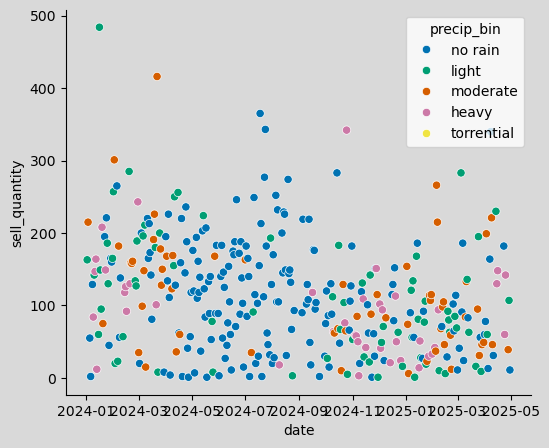

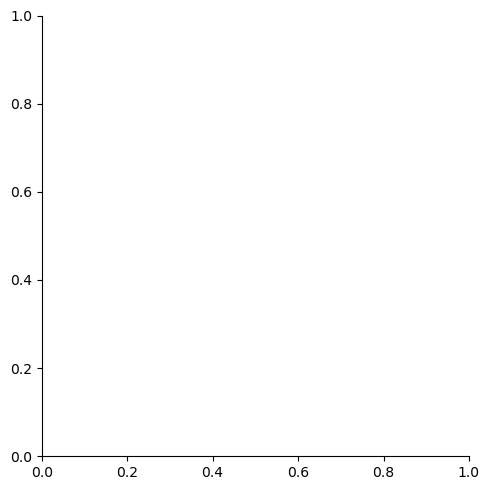

In [138]:
set_plot_style()

df['sell_quantity_'] = df['sell_quantity'].copy().fillna(0)

sns.scatterplot(x = df['date'], y = df['sell_quantity'], hue = df['precip_bin'])
sns.lmplot(x = 'date', y = 'sell_quantity_', data = df, ci = None)
                    
plt.gcf().set_size_inches(12, 6)
                    
plt.show()
plt.close()

#PlotScatterHue(df, df['date'], df['sell_quantity'], df['precip_bin'], df['avg_sell_quantity_last_7d'], "", 12, 6, "")

In [35]:
df.to_csv("../data/processed/02_EDA.csv", index = False)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       486 non-null    datetime64[ns]
 1   sell_quantity              379 non-null    float64       
 2   sell_value                 379 non-null    float64       
 3   buy_quantity               164 non-null    float64       
 4   buy_value                  485 non-null    float64       
 5   daily_balance              486 non-null    int64         
 6   inventory                  486 non-null    int64         
 7   avg_temperature            486 non-null    float64       
 8   precipitation              461 non-null    float64       
 9   incc                       486 non-null    float64       
 10  fuel_price                 486 non-null    float64       
 11  is_holiday                 486 non-null    int64         
 12  price_ma